# Project Notebook

This notebook includes the following:


In [1]:
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data2.cc"

### Plot Stroke Function

In [2]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(14.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

### Data Augmentation Functions

In [3]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

## Load and Clean Data

NOTE: Load gestures_data folder that contains .json files with collected data

In [4]:
import glob
import json

all_strokes = []
for filename in glob.glob("gestures_data/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    all_strokes.append(stroke)

# Total number of strokes
print("Total number of strokes collected: ", len(all_strokes))

strokes = [] # initialize variable to store strokes with labels
for stroke in all_strokes:
  if stroke["label"] != "":
    strokes.append(stroke)

# Total number of strokes with labels
print("Total number of strokes with labels: ", len(strokes))


Total number of strokes collected:  1456
Total number of strokes with labels:  1317


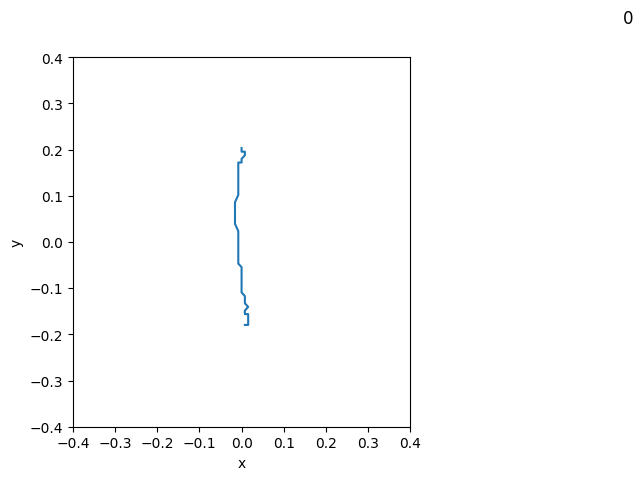

In [5]:
plot_stroke(strokes[10])

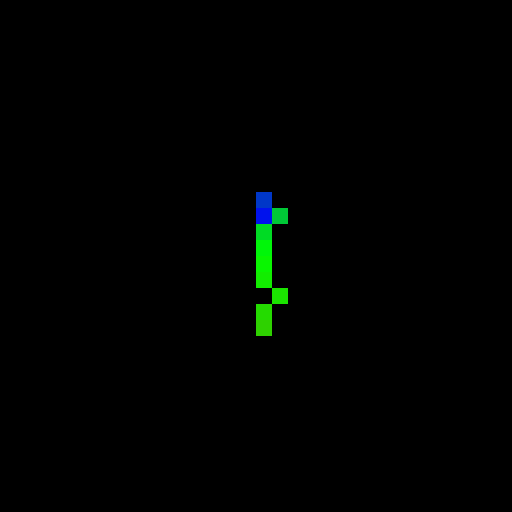

In [6]:
raster = rasterize_stroke(strokes[1]["strokePoints"], 0.7, 0.7, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

## Rasterize Strokes and Save Images

In [7]:
!rm -rf test
!rm -rf train
!rm -rf validation

### Rasterize and Save Image Functions

In [8]:
from pathlib import Path
import shutil

X_RANGE = 0.7
Y_RANGE = 0.7

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
      label_path = Path(root_folder, label)
      ensure_empty_dir(label_path)

  label_counts = {}
  label_augment_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))

    # For counting how many un-augmented images are there for each label
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1

    # Rasterize normal strokes
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))

    #Augment and Rasterize a set of strokes
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))
      #label count for augmented images
      if label not in label_augment_counts:
        label_augment_counts[label] = 0
      label_augment_count = label_augment_counts[label]
      label_augment_counts[label] += 1
  print('label counts of un-augmented images for', root_folder, ': ', label_counts)
  print('label counts of augmented images for', root_folder, ': ', label_augment_counts)


### Split dataset into Training, Validation, and Test set

In [9]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)
print(len(shuffled_strokes))
test_percentage = 20
validation_percentage = 20
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

1317


In [10]:
# Save strokes into folder
save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

label counts of un-augmented images for test :  {'1': 60, '2': 50, '4': 54, '3': 44, '0': 55}
label counts of augmented images for test :  {'1': 600, '2': 500, '4': 540, '3': 440, '0': 550}
label counts of un-augmented images for validation :  {'3': 57, '2': 35, '0': 58, '4': 65, '1': 48}
label counts of augmented images for validation :  {}
label counts of un-augmented images for train :  {'3': 156, '1': 166, '2': 140, '0': 144, '4': 185}
label counts of augmented images for train :  {'3': 1560, '1': 1660, '2': 1400, '0': 1440, '4': 1850}


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 263 files belonging to 5 classes.
Found 8701 files belonging to 5 classes.


### Preview of Rasterized Strokes after split

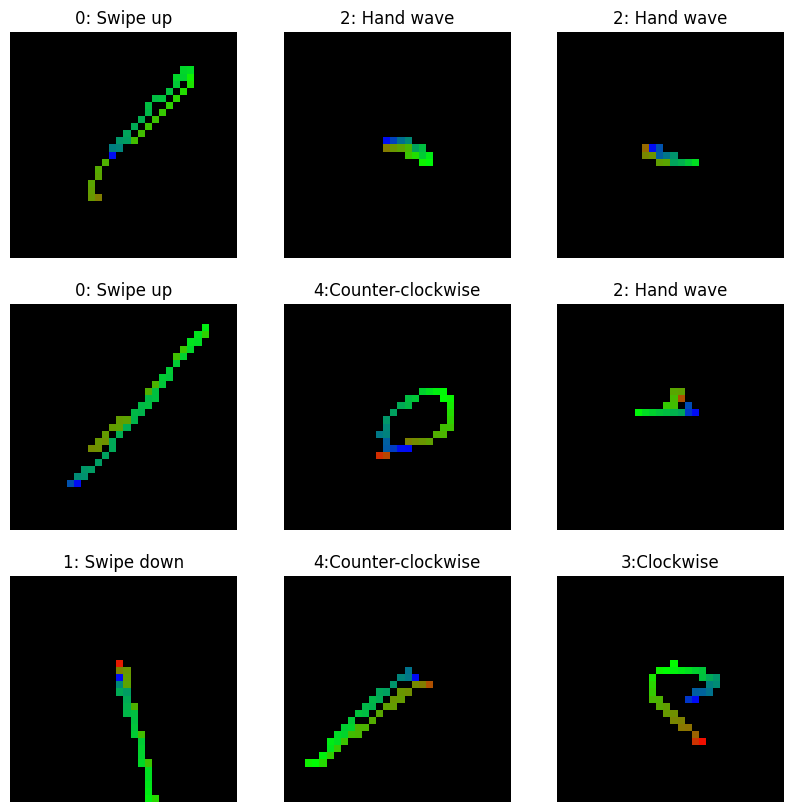

In [12]:
import matplotlib.pyplot as plt
classes = ["0: Swipe up", "1: Swipe down", "2: Hand wave", "3:Clockwise", "4:Counter-clockwise"]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    ax.set_title(classes[np.argmax(labels[i])])

## Model

### Create Model

In [47]:
# from keras import layers

# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)
#     x = layers.Rescaling(1.0 / 255)(inputs)

#     # TODO: build your own CNN model here
#     # Some useful functions to consider:
#     # layers.Conv2D, layers.BatchNormalization, layers.Activation("relu"), layers.Dropout, layers.GlobalAveragePooling2D()
#     x = layers.Conv2D(16,3,strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.Dropout(0.5)(x)

#     x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.Dropout(0.5)(x)

#     # x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
#     # x = layers.BatchNormalization()(x)
#     # x = layers.Activation("relu")(x)
#     # x = layers.Dropout(0.5)(x)

#     x = layers.GlobalAveragePooling2D()(x)

#     activation = "softmax"
#     units = num_classes
#     outputs = layers.Dense(units, activation=activation)(x)
#     return keras.Model(inputs, outputs)

In [51]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)

    # TODO: build your own CNN model here
    # Some useful functions to consider:
    # layers.Conv2D, layers.BatchNormalization, layers.Activation("relu"), layers.Dropout, layers.GlobalAveragePooling2D()
    x = layers.Conv2D(8,3,strides=2, padding="same")(x)
    #x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    #x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    #x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    outputs = layers.Dense(num_classes, activation=activation)(x)
    return keras.Model(inputs, outputs)

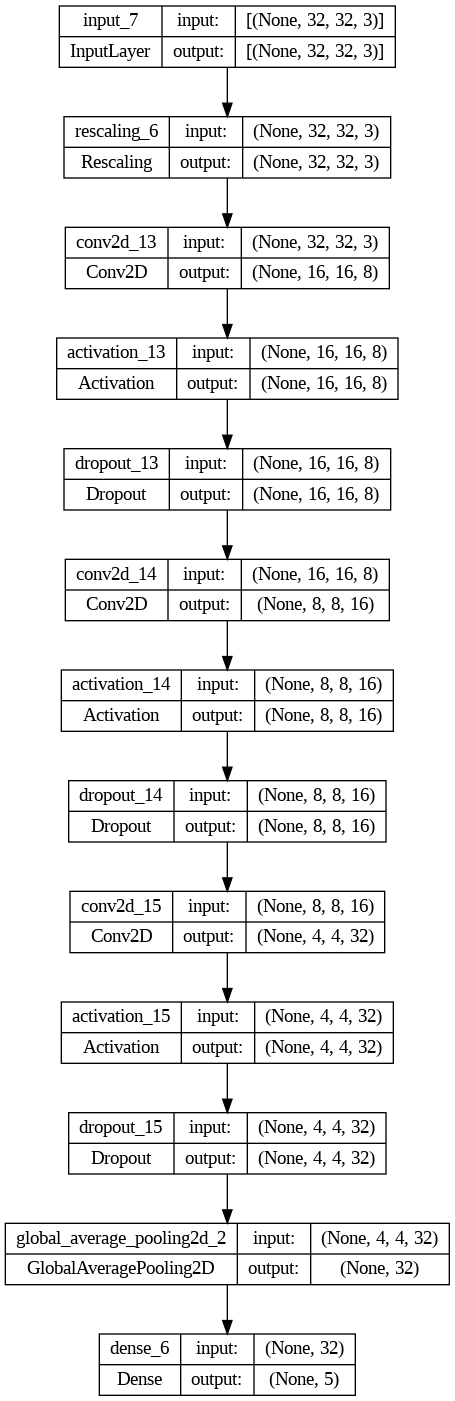

In [52]:
model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=5)
keras.utils.plot_model(model, show_shapes=True)

### Train Model

In [53]:
epochs = 40

# callbacks = [
#     keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.h5"),
# ]
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [54]:
history = model.fit(
    train_ds, epochs=epochs, validation_data=validation_ds
) #,callbacks=callbacks

Epoch 1/40
544/544 [==============================] - 6s 9ms/step - loss: 1.2704 - accuracy: 0.4410 - val_loss: 0.8613 - val_accuracy: 0.6350
Epoch 2/40
544/544 [==============================] - 6s 12ms/step - loss: 0.9443 - accuracy: 0.5960 - val_loss: 0.7493 - val_accuracy: 0.7034
Epoch 3/40
544/544 [==============================] - 5s 9ms/step - loss: 0.8679 - accuracy: 0.6303 - val_loss: 0.7008 - val_accuracy: 0.7186
Epoch 4/40
544/544 [==============================] - 7s 12ms/step - loss: 0.8372 - accuracy: 0.6437 - val_loss: 0.7065 - val_accuracy: 0.7072
Epoch 5/40
544/544 [==============================] - 7s 14ms/step - loss: 0.8164 - accuracy: 0.6574 - val_loss: 0.6658 - val_accuracy: 0.7224
Epoch 6/40
544/544 [==============================] - 5s 9ms/step - loss: 0.7845 - accuracy: 0.6641 - val_loss: 0.6307 - val_accuracy: 0.7186
Epoch 7/40
544/544 [==============================] - 6s 11ms/step - loss: 0.7676 - accuracy: 0.6782 - val_loss: 0.6255 - val_accuracy: 0.7681
Ep

### Display Loss and Accuracy of Model

In [55]:
#History functions
def show_history_loss(history):
    '''Function to show history loss after model training'''
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'test_loss'], loc='best')
    plt.show()

def show_history_accuracy(history):
    '''Function to show history accuracy after model training'''
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


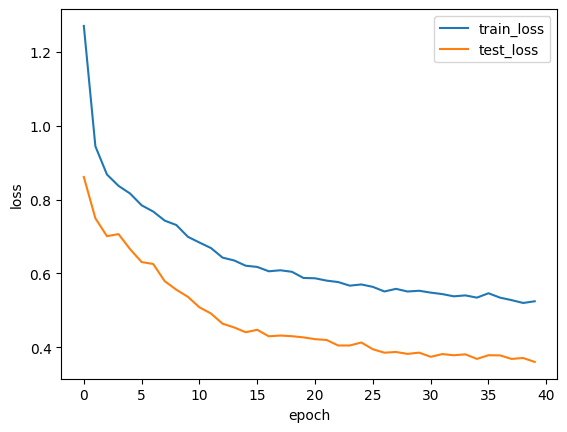

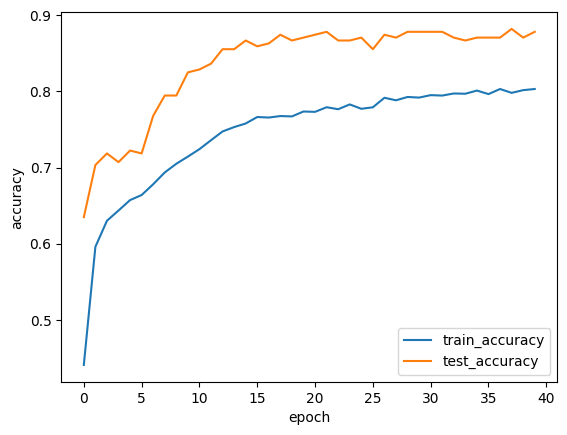

In [56]:
# Store history
# Store the trained model in file
model.save("model.h5")

# Save history to a json file
json.dump(history.history, open('model_history.json', 'w'))

# Show history
model_history_dict = json.load(open('model_history.json', 'r'))
show_history_loss(model_history_dict)
show_history_accuracy(model_history_dict)

### Evaluate Model

In [57]:
# Evaluate on one image
img = keras.preprocessing.image.load_img("test/0/1.png", target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array, verbose=0).flatten()
print("predictions: ", predictions)
print("class: ", classes[np.argmax(predictions)])

predictions:  [4.7089517e-01 5.2892011e-01 1.6726292e-04 2.9156107e-07 1.7089313e-05]
class:  1: Swipe down


In [58]:
def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array, verbose=0).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  img_class = classes[np.argmax(predictions)]
  return (predicted_label_index, predicted_score, img_class)

label: 2
2 expected, 4 found with score 0.574041


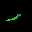

2 expected, 1 found with score 0.407288


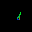

2 expected, 1 found with score 0.787538


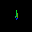

2 expected, 1 found with score 0.569828


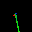

2 expected, 1 found with score 0.824597


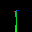

2 expected, 1 found with score 0.691077


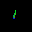

2 expected, 1 found with score 0.760688


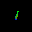

2 expected, 3 found with score 0.367739


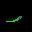

2 expected, 1 found with score 0.690989


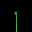

2 expected, 1 found with score 0.776846


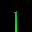

2 expected, 1 found with score 0.829322


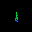

2 expected, 1 found with score 0.545232


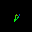

2 expected, 3 found with score 0.927854


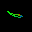

2 expected, 1 found with score 0.540870


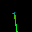

2 expected, 1 found with score 0.878359


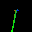

2 expected, 1 found with score 0.451263


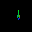

2 expected, 1 found with score 0.538518


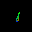

2 expected, 4 found with score 0.483272


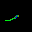

2 expected, 1 found with score 0.467566


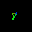

2 expected, 1 found with score 0.443282


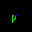

2 expected, 1 found with score 0.712857


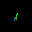

2 expected, 0 found with score 0.354631


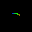

2 expected, 3 found with score 0.782568


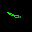

2 expected, 0 found with score 0.478269


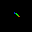

2 expected, 3 found with score 0.515400


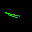

2 expected, 4 found with score 0.719614


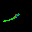

2 expected, 1 found with score 0.320751


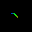

2 expected, 1 found with score 0.621645


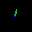

2 expected, 1 found with score 0.635090


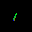

2 expected, 3 found with score 0.338982


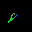

2 expected, 1 found with score 0.802306


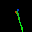

2 expected, 3 found with score 0.450009


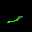

2 expected, 0 found with score 0.377575


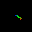

2 expected, 1 found with score 0.754675


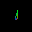

2 expected, 1 found with score 0.582104


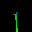

2 expected, 1 found with score 0.594207


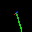

2 expected, 1 found with score 0.632682


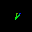

2 expected, 1 found with score 0.791661


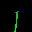

2 expected, 1 found with score 0.813274


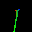

2 expected, 3 found with score 0.806988


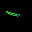

2 expected, 4 found with score 0.295601


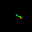

label: 3
3 expected, 2 found with score 0.507271


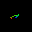

3 expected, 2 found with score 0.931159


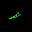

3 expected, 2 found with score 0.680891


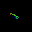

3 expected, 2 found with score 0.875924


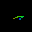

3 expected, 4 found with score 0.855320


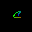

3 expected, 2 found with score 0.741082


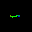

3 expected, 4 found with score 0.614266


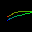

3 expected, 4 found with score 0.729622


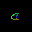

3 expected, 2 found with score 0.637093


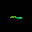

3 expected, 2 found with score 0.905141


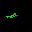

3 expected, 2 found with score 0.865259


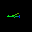

3 expected, 4 found with score 0.551421


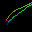

3 expected, 2 found with score 0.890187


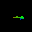

3 expected, 2 found with score 0.768325


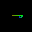

3 expected, 2 found with score 0.889886


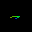

3 expected, 2 found with score 0.883250


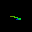

3 expected, 2 found with score 0.349641


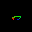

3 expected, 4 found with score 0.337382


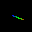

3 expected, 2 found with score 0.515370


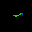

3 expected, 0 found with score 0.711682


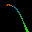

3 expected, 2 found with score 0.659609


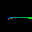

3 expected, 2 found with score 0.828184


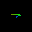

3 expected, 2 found with score 0.594282


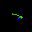

3 expected, 2 found with score 0.549429


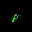

3 expected, 2 found with score 0.799465


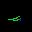

3 expected, 2 found with score 0.844843


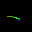

3 expected, 4 found with score 0.645311


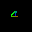

3 expected, 2 found with score 0.843826


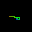

3 expected, 4 found with score 0.674959


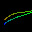

3 expected, 2 found with score 0.687191


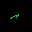

3 expected, 2 found with score 0.675839


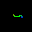

3 expected, 2 found with score 0.647967


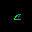

3 expected, 2 found with score 0.667631


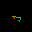

3 expected, 2 found with score 0.923821


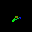

3 expected, 2 found with score 0.898669


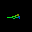

3 expected, 2 found with score 0.940873


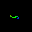

3 expected, 2 found with score 0.914528


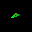

3 expected, 2 found with score 0.890761


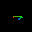

3 expected, 2 found with score 0.669199


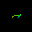

3 expected, 4 found with score 0.655645


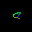

3 expected, 2 found with score 0.564444


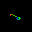

3 expected, 2 found with score 0.786211


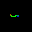

3 expected, 2 found with score 0.485476


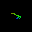

3 expected, 2 found with score 0.389237


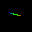

3 expected, 2 found with score 0.905143


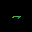

3 expected, 2 found with score 0.451389


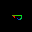

3 expected, 2 found with score 0.333647


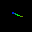

3 expected, 2 found with score 0.713166


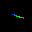

3 expected, 2 found with score 0.712584


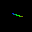

3 expected, 2 found with score 0.927624


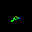

3 expected, 2 found with score 0.901345


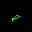

3 expected, 2 found with score 0.418118


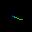

3 expected, 2 found with score 0.943725


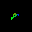

3 expected, 4 found with score 0.800894


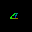

3 expected, 2 found with score 0.663095


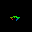

3 expected, 2 found with score 0.796697


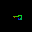

3 expected, 2 found with score 0.535170


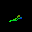

3 expected, 2 found with score 0.908746


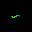

3 expected, 4 found with score 0.621567


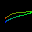

3 expected, 0 found with score 0.405938


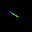

3 expected, 2 found with score 0.531465


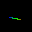

3 expected, 2 found with score 0.952720


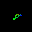

3 expected, 2 found with score 0.496245


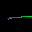

3 expected, 2 found with score 0.628068


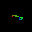

3 expected, 4 found with score 0.842081


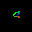

3 expected, 0 found with score 0.651655


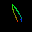

3 expected, 2 found with score 0.906735


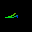

3 expected, 2 found with score 0.801190


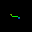

3 expected, 4 found with score 0.694963


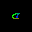

3 expected, 2 found with score 0.846845


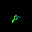

3 expected, 0 found with score 0.376563


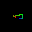

3 expected, 2 found with score 0.564767


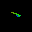

3 expected, 2 found with score 0.478394


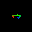

3 expected, 4 found with score 0.324118


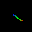

3 expected, 4 found with score 0.809553


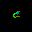

3 expected, 2 found with score 0.548969


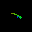

3 expected, 2 found with score 0.737973


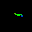

3 expected, 2 found with score 0.289050


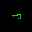

3 expected, 2 found with score 0.591284


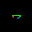

3 expected, 4 found with score 0.632691


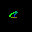

3 expected, 2 found with score 0.695643


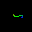

3 expected, 2 found with score 0.687214


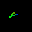

3 expected, 2 found with score 0.950288


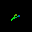

3 expected, 2 found with score 0.614269


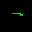

3 expected, 2 found with score 0.887817


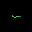

3 expected, 2 found with score 0.731919


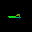

3 expected, 2 found with score 0.942142


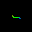

3 expected, 2 found with score 0.908555


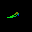

3 expected, 2 found with score 0.898382


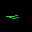

3 expected, 0 found with score 0.711848


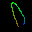

3 expected, 4 found with score 0.321904


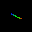

3 expected, 2 found with score 0.884435


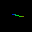

3 expected, 2 found with score 0.888308


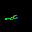

3 expected, 2 found with score 0.721116


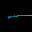

3 expected, 1 found with score 0.487680


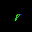

3 expected, 4 found with score 0.522391


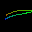

label: 1
1 expected, 0 found with score 0.559684


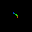

1 expected, 0 found with score 0.749534


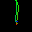

1 expected, 0 found with score 0.754139


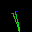

1 expected, 2 found with score 0.665295


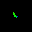

1 expected, 0 found with score 0.733664


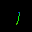

1 expected, 0 found with score 0.733249


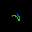

1 expected, 0 found with score 0.702229


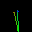

1 expected, 0 found with score 0.777036


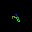

1 expected, 0 found with score 0.522626


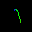

1 expected, 0 found with score 0.531686


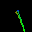

1 expected, 0 found with score 0.880743


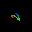

1 expected, 0 found with score 0.504413


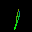

1 expected, 0 found with score 0.525075


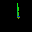

1 expected, 0 found with score 0.845539


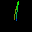

1 expected, 0 found with score 0.563659


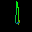

1 expected, 0 found with score 0.564205


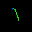

1 expected, 0 found with score 0.727321


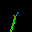

1 expected, 0 found with score 0.651729


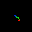

1 expected, 0 found with score 0.704396


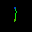

1 expected, 0 found with score 0.545588


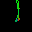

1 expected, 0 found with score 0.572566


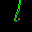

1 expected, 0 found with score 0.645952


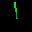

1 expected, 0 found with score 0.535743


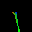

1 expected, 0 found with score 0.502751


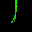

1 expected, 0 found with score 0.828239


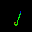

1 expected, 0 found with score 0.581446


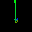

1 expected, 0 found with score 0.858425


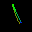

1 expected, 0 found with score 0.651132


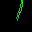

1 expected, 0 found with score 0.502541


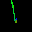

1 expected, 0 found with score 0.565283


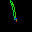

1 expected, 0 found with score 0.533260


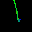

1 expected, 0 found with score 0.745472


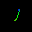

1 expected, 0 found with score 0.904479


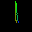

1 expected, 0 found with score 0.697999


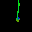

1 expected, 0 found with score 0.775260


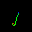

1 expected, 0 found with score 0.794715


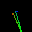

1 expected, 2 found with score 0.628489


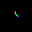

1 expected, 0 found with score 0.519490


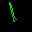

1 expected, 0 found with score 0.669108


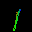

1 expected, 0 found with score 0.738766


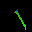

1 expected, 3 found with score 0.650203


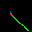

1 expected, 0 found with score 0.516945


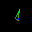

1 expected, 0 found with score 0.721943


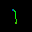

1 expected, 0 found with score 0.754132


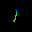

1 expected, 0 found with score 0.403254


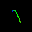

1 expected, 0 found with score 0.631964


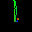

1 expected, 0 found with score 0.719533


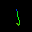

1 expected, 0 found with score 0.617725


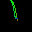

1 expected, 0 found with score 0.787763


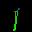

1 expected, 0 found with score 0.607552


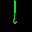

1 expected, 0 found with score 0.531695


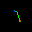

1 expected, 0 found with score 0.676755


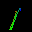

1 expected, 0 found with score 0.526226


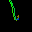

1 expected, 0 found with score 0.578009


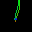

1 expected, 0 found with score 0.664571


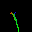

1 expected, 0 found with score 0.617539


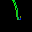

1 expected, 0 found with score 0.745033


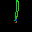

1 expected, 0 found with score 0.603541


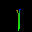

1 expected, 0 found with score 0.672610


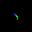

1 expected, 0 found with score 0.572385


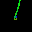

1 expected, 0 found with score 0.569772


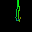

1 expected, 4 found with score 0.460765


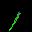

1 expected, 0 found with score 0.830739


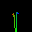

1 expected, 0 found with score 0.573170


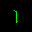

1 expected, 0 found with score 0.786589


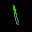

1 expected, 0 found with score 0.550614


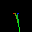

1 expected, 0 found with score 0.571639


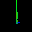

1 expected, 0 found with score 0.886284


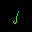

1 expected, 0 found with score 0.529526


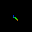

1 expected, 0 found with score 0.696686


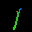

1 expected, 0 found with score 0.551327


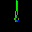

1 expected, 0 found with score 0.763435


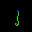

1 expected, 0 found with score 0.747557


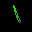

1 expected, 2 found with score 0.607470


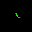

1 expected, 0 found with score 0.799790


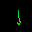

1 expected, 0 found with score 0.761757


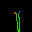

1 expected, 0 found with score 0.713516


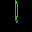

1 expected, 0 found with score 0.753791


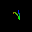

1 expected, 0 found with score 0.575217


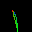

1 expected, 0 found with score 0.853171


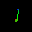

1 expected, 0 found with score 0.711773


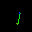

1 expected, 0 found with score 0.521101


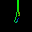

1 expected, 0 found with score 0.778316


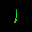

1 expected, 0 found with score 0.500342


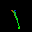

1 expected, 2 found with score 0.467843


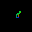

1 expected, 0 found with score 0.720948


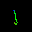

1 expected, 4 found with score 0.601142


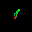

1 expected, 0 found with score 0.540026


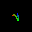

1 expected, 0 found with score 0.554697


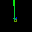

1 expected, 0 found with score 0.536812


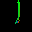

1 expected, 0 found with score 0.748948


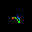

1 expected, 0 found with score 0.747769


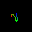

1 expected, 0 found with score 0.456283


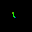

1 expected, 0 found with score 0.553699


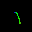

1 expected, 0 found with score 0.937948


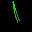

1 expected, 0 found with score 0.634492


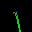

1 expected, 2 found with score 0.401767


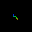

1 expected, 0 found with score 0.584048


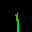

1 expected, 0 found with score 0.643789


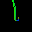

1 expected, 0 found with score 0.503747


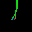

1 expected, 0 found with score 0.831138


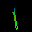

1 expected, 0 found with score 0.561876


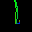

1 expected, 0 found with score 0.736266


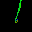

1 expected, 0 found with score 0.894237


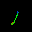

1 expected, 2 found with score 0.466069


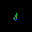

1 expected, 0 found with score 0.567115


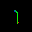

1 expected, 2 found with score 0.658412


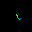

1 expected, 0 found with score 0.518524


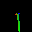

1 expected, 0 found with score 0.837388


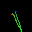

1 expected, 0 found with score 0.664893


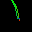

1 expected, 0 found with score 0.579815


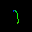

1 expected, 0 found with score 0.701993


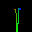

1 expected, 2 found with score 0.443744


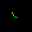

1 expected, 0 found with score 0.692453


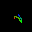

1 expected, 0 found with score 0.895134


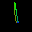

1 expected, 0 found with score 0.440053


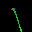

1 expected, 0 found with score 0.646529


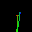

1 expected, 0 found with score 0.861143


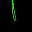

1 expected, 0 found with score 0.722445


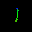

1 expected, 0 found with score 0.515445


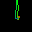

1 expected, 0 found with score 0.488396


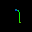

1 expected, 0 found with score 0.537025


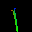

1 expected, 2 found with score 0.451486


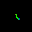

1 expected, 0 found with score 0.628482


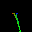

1 expected, 0 found with score 0.522057


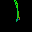

1 expected, 0 found with score 0.396994


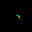

1 expected, 0 found with score 0.683810


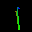

1 expected, 0 found with score 0.683517


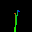

1 expected, 0 found with score 0.816243


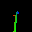

1 expected, 0 found with score 0.617669


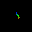

1 expected, 0 found with score 0.648423


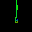

1 expected, 0 found with score 0.477725


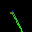

1 expected, 0 found with score 0.889591


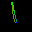

1 expected, 0 found with score 0.613773


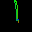

1 expected, 0 found with score 0.679932


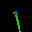

1 expected, 0 found with score 0.567059


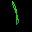

1 expected, 0 found with score 0.649861


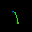

1 expected, 0 found with score 0.615528


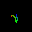

1 expected, 0 found with score 0.750739


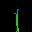

1 expected, 0 found with score 0.699175


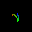

1 expected, 0 found with score 0.614340


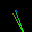

1 expected, 0 found with score 0.757834


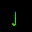

1 expected, 0 found with score 0.554976


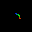

1 expected, 0 found with score 0.894099


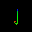

1 expected, 0 found with score 0.556935


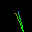

1 expected, 0 found with score 0.558955


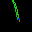

1 expected, 0 found with score 0.626681


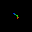

1 expected, 0 found with score 0.917761


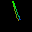

1 expected, 0 found with score 0.761579


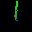

1 expected, 0 found with score 0.787403


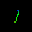

1 expected, 2 found with score 0.787608


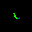

1 expected, 0 found with score 0.744335


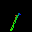

1 expected, 0 found with score 0.574477


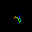

1 expected, 0 found with score 0.551784


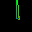

1 expected, 0 found with score 0.651567


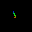

1 expected, 0 found with score 0.520524


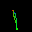

1 expected, 0 found with score 0.824534


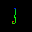

1 expected, 0 found with score 0.753546


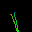

1 expected, 0 found with score 0.801266


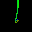

1 expected, 0 found with score 0.624827


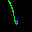

1 expected, 0 found with score 0.487988


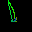

1 expected, 0 found with score 0.758730


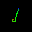

1 expected, 0 found with score 0.624758


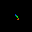

1 expected, 0 found with score 0.791622


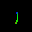

1 expected, 0 found with score 0.513013


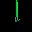

1 expected, 0 found with score 0.665713


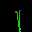

label: 4
4 expected, 0 found with score 0.568380


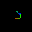

4 expected, 1 found with score 0.418976


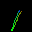

4 expected, 2 found with score 0.717515


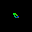

4 expected, 2 found with score 0.923235


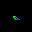

4 expected, 0 found with score 0.523441


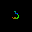

4 expected, 1 found with score 0.731621


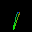

4 expected, 0 found with score 0.468631


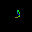

4 expected, 1 found with score 0.744100


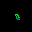

4 expected, 1 found with score 0.439432


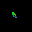

4 expected, 1 found with score 0.809663


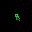

4 expected, 2 found with score 0.702856


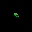

4 expected, 1 found with score 0.415687


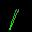

4 expected, 2 found with score 0.733958


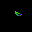

4 expected, 3 found with score 0.463570


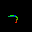

4 expected, 2 found with score 0.408889


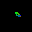

4 expected, 1 found with score 0.378413


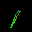

4 expected, 1 found with score 0.398248


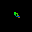

4 expected, 1 found with score 0.782853


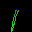

4 expected, 1 found with score 0.482927


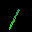

4 expected, 0 found with score 0.510320


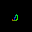

4 expected, 1 found with score 0.530081


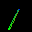

4 expected, 1 found with score 0.460040


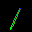

4 expected, 0 found with score 0.345392


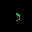

4 expected, 2 found with score 0.479363


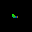

4 expected, 1 found with score 0.384131


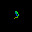

4 expected, 1 found with score 0.435951


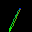

4 expected, 2 found with score 0.665411


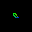

label: 0
0 expected, 1 found with score 0.415747


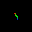

0 expected, 2 found with score 0.866147


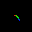

0 expected, 1 found with score 0.703963


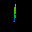

0 expected, 2 found with score 0.631654


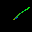

0 expected, 1 found with score 0.791588


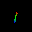

0 expected, 1 found with score 0.645848


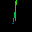

0 expected, 1 found with score 0.530520


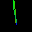

0 expected, 1 found with score 0.572918


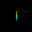

0 expected, 1 found with score 0.583898


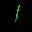

0 expected, 1 found with score 0.613652


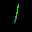

0 expected, 1 found with score 0.553124


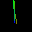

0 expected, 1 found with score 0.582929


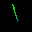

0 expected, 1 found with score 0.539463


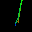

0 expected, 1 found with score 0.513310


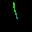

0 expected, 1 found with score 0.633391


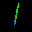

0 expected, 1 found with score 0.521631


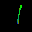

0 expected, 1 found with score 0.617107


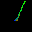

0 expected, 1 found with score 0.516233


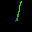

0 expected, 3 found with score 0.848911


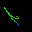

0 expected, 3 found with score 0.985553


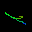

0 expected, 1 found with score 0.536342


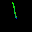

0 expected, 3 found with score 0.577168


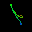

0 expected, 1 found with score 0.669523


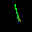

0 expected, 1 found with score 0.504557


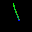

0 expected, 1 found with score 0.502783


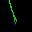

0 expected, 3 found with score 0.391006


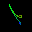

0 expected, 2 found with score 0.367020


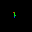

0 expected, 2 found with score 0.342925


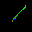

0 expected, 1 found with score 0.542724


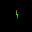

0 expected, 1 found with score 0.575786


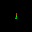

0 expected, 1 found with score 0.611217


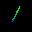

0 expected, 1 found with score 0.623541


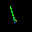

0 expected, 1 found with score 0.499016


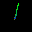

0 expected, 1 found with score 0.459160


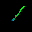

0 expected, 1 found with score 0.448690


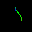

0 expected, 1 found with score 0.518205


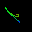

0 expected, 1 found with score 0.617690


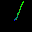

0 expected, 1 found with score 0.586904


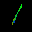

0 expected, 1 found with score 0.495355


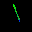

0 expected, 3 found with score 0.614535


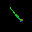

0 expected, 1 found with score 0.669104


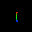

0 expected, 1 found with score 0.509064


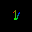

0 expected, 1 found with score 0.550295


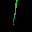

0 expected, 1 found with score 0.539805


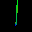

0 expected, 1 found with score 0.621935


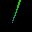

0 expected, 2 found with score 0.458663


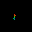

0 expected, 1 found with score 0.572204


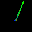

0 expected, 3 found with score 0.894126


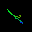

0 expected, 2 found with score 0.494065


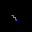

0 expected, 1 found with score 0.623417


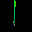

0 expected, 2 found with score 0.486977


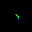

0 expected, 1 found with score 0.647773


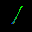

0 expected, 1 found with score 0.530337


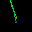

0 expected, 1 found with score 0.500016


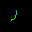

0 expected, 1 found with score 0.478907


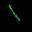

0 expected, 1 found with score 0.552141


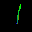

0 expected, 1 found with score 0.555460


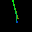

0 expected, 1 found with score 0.511241


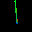

0 expected, 1 found with score 0.567998


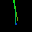

0 expected, 1 found with score 0.659962


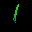

0 expected, 3 found with score 0.986554


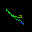

0 expected, 1 found with score 0.596975


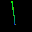

0 expected, 1 found with score 0.536312


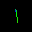

0 expected, 1 found with score 0.694242


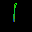

0 expected, 1 found with score 0.581562


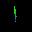

0 expected, 1 found with score 0.563454


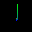

0 expected, 1 found with score 0.662831


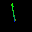

0 expected, 2 found with score 0.379608


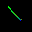

0 expected, 1 found with score 0.745816


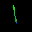

0 expected, 1 found with score 0.582537


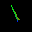

0 expected, 3 found with score 0.931348


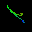

0 expected, 1 found with score 0.460744


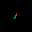

0 expected, 1 found with score 0.586706


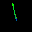

0 expected, 1 found with score 0.515288


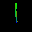

0 expected, 4 found with score 0.664615


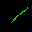

0 expected, 2 found with score 0.898169


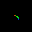

0 expected, 1 found with score 0.590737


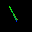

0 expected, 1 found with score 0.541422


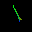

0 expected, 1 found with score 0.694565


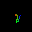

0 expected, 1 found with score 0.542371


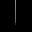

0 expected, 1 found with score 0.555283


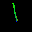

0 expected, 1 found with score 0.622672


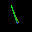

0 expected, 4 found with score 0.657689


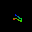

0 expected, 1 found with score 0.575824


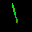

0 expected, 1 found with score 0.494894


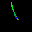

0 expected, 1 found with score 0.442505


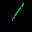

0 expected, 1 found with score 0.523075


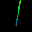

0 expected, 1 found with score 0.411853


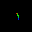

0 expected, 1 found with score 0.611254


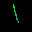

0 expected, 3 found with score 0.955546


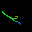

0 expected, 1 found with score 0.670128


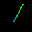

0 expected, 1 found with score 0.570357


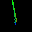

0 expected, 1 found with score 0.840615


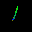

0 expected, 1 found with score 0.596413


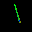

0 expected, 1 found with score 0.498537


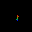

0 expected, 2 found with score 0.517769


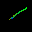

0 expected, 1 found with score 0.737994


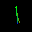

0 expected, 1 found with score 0.598392


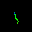

0 expected, 1 found with score 0.469656


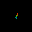

0 expected, 1 found with score 0.348496


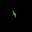

0 expected, 4 found with score 0.723379


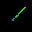

0 expected, 1 found with score 0.528670


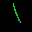

0 expected, 1 found with score 0.543917


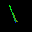

0 expected, 2 found with score 0.389495


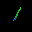

0 expected, 1 found with score 0.539488


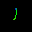

0 expected, 2 found with score 0.765049


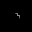

0 expected, 3 found with score 0.900921


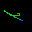

0 expected, 1 found with score 0.557451


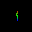

0 expected, 1 found with score 0.566361


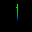

0 expected, 2 found with score 0.482796


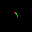

0 expected, 1 found with score 0.541535


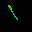

0 expected, 1 found with score 0.534167


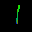

0 expected, 1 found with score 0.503343


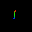

0 expected, 1 found with score 0.567934


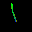

0 expected, 2 found with score 0.805505


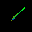

0 expected, 1 found with score 0.735741


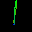

0 expected, 3 found with score 0.963109


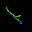

0 expected, 1 found with score 0.743280


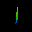

0 expected, 1 found with score 0.610784


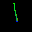

0 expected, 2 found with score 0.534852


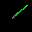

0 expected, 1 found with score 0.592853


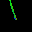

0 expected, 1 found with score 0.528920


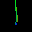

0 expected, 1 found with score 0.560989


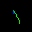

0 expected, 1 found with score 0.640710


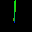

0 expected, 1 found with score 0.535623


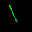

0 expected, 1 found with score 0.564036


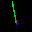

0 expected, 1 found with score 0.675391


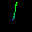

0 expected, 1 found with score 0.504186


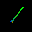

0 expected, 1 found with score 0.539826


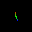

84.1% correct (N=2893, 135 below threshold)


In [59]:
from IPython.display import Image, display

SCORE_THRESHOLD = 0.5

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test/*"):
  label = int(label_dir.replace("test/", ""))
  print("label:", label)
  for filename in glob.glob(label_dir + "/*.png"):
    index, score, img_class = predict_image(model, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
    #   continue
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
      print("%d expected, %d found with score %f" % (label, index, score))
      display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
print("%.1f%% correct (N=%d, %d below threshold)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

In [60]:
model.save(SAVED_MODEL_FILENAME)

In [61]:
import os

converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("train/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
#model_tflite = converter.convert()
## MY CODE
#   data_gen = train_ds.take(200)
#   for image, label in data_gen:
#     # Ensure the data is in float32 before casting to uint8 to simulate the quantization process
#     image = tf.cast(image, tf.float32)
#     yield [image]

# # Passing the baseline Keras model to the TF Lite Converter.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset

# # Using Integer Quantization.
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# # Setting the input and output tensors to uint8.
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

# # Force the model to quantize the input layer by ensuring all ops are int8
# converter.target_spec.supported_types = [tf.int8]

# Converting the model.
model_FIQ = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_FIQ)

# Print the model size
model_size = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)
print(f"Model size: {model_size} bytes = {model_size/1024/1024} MB")

Model size: 11352 bytes = 0.01082611083984375 MB


In [62]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [63]:
predict_tflite(model_no_quant_tflite, "test/4/2.png")

(4, 0.9948354)

In [64]:
predict_tflite(model_FIQ, "test/4/2.png")

(4, 0.9921875)

2 expected, 4 found with score 0.542969


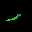

2 expected, 1 found with score 0.402344


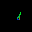

2 expected, 1 found with score 0.761719


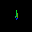

2 expected, 1 found with score 0.566406


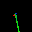

2 expected, 1 found with score 0.820312


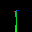

2 expected, 1 found with score 0.667969


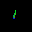

2 expected, 0 found with score 0.320312


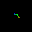

2 expected, 1 found with score 0.750000


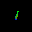

2 expected, 1 found with score 0.664062


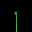

2 expected, 1 found with score 0.773438


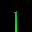

2 expected, 1 found with score 0.832031


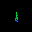

2 expected, 1 found with score 0.527344


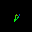

2 expected, 3 found with score 0.929688


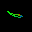

2 expected, 1 found with score 0.531250


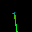

2 expected, 1 found with score 0.886719


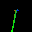

2 expected, 0 found with score 0.406250


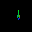

2 expected, 1 found with score 0.531250


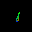

2 expected, 1 found with score 0.460938


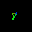

2 expected, 1 found with score 0.406250


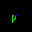

2 expected, 1 found with score 0.718750


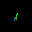

2 expected, 0 found with score 0.343750


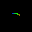

2 expected, 3 found with score 0.796875


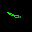

2 expected, 0 found with score 0.488281


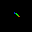

2 expected, 3 found with score 0.531250


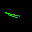

2 expected, 4 found with score 0.660156


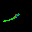

2 expected, 1 found with score 0.316406


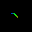

2 expected, 1 found with score 0.578125


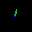

2 expected, 1 found with score 0.632812


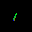

2 expected, 3 found with score 0.375000


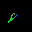

2 expected, 1 found with score 0.796875


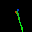

2 expected, 3 found with score 0.468750


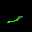

2 expected, 0 found with score 0.386719


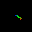

2 expected, 1 found with score 0.742188


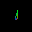

2 expected, 1 found with score 0.566406


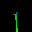

2 expected, 1 found with score 0.601562


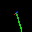

2 expected, 1 found with score 0.613281


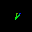

2 expected, 1 found with score 0.773438


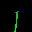

2 expected, 1 found with score 0.820312


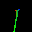

2 expected, 3 found with score 0.839844


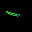

2 expected, 0 found with score 0.300781


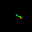

3 expected, 2 found with score 0.527344


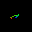

3 expected, 2 found with score 0.937500


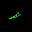

3 expected, 2 found with score 0.671875


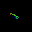

3 expected, 2 found with score 0.878906


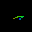

3 expected, 4 found with score 0.835938


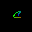

3 expected, 2 found with score 0.738281


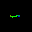

3 expected, 4 found with score 0.601562


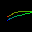

3 expected, 4 found with score 0.714844


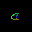

3 expected, 2 found with score 0.597656


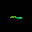

3 expected, 2 found with score 0.914062


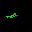

3 expected, 2 found with score 0.855469


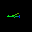

3 expected, 4 found with score 0.531250


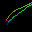

3 expected, 2 found with score 0.882812


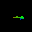

3 expected, 2 found with score 0.761719


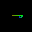

3 expected, 2 found with score 0.882812


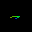

3 expected, 2 found with score 0.882812


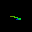

3 expected, 2 found with score 0.351562


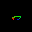

3 expected, 2 found with score 0.515625


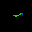

3 expected, 0 found with score 0.726562


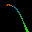

3 expected, 2 found with score 0.632812


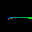

3 expected, 2 found with score 0.832031


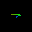

3 expected, 2 found with score 0.601562


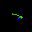

3 expected, 2 found with score 0.574219


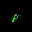

3 expected, 2 found with score 0.808594


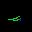

3 expected, 2 found with score 0.847656


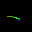

3 expected, 4 found with score 0.605469


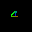

3 expected, 2 found with score 0.816406


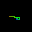

3 expected, 4 found with score 0.664062


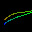

3 expected, 2 found with score 0.691406


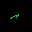

3 expected, 2 found with score 0.664062


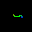

3 expected, 2 found with score 0.667969


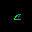

3 expected, 2 found with score 0.660156


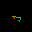

3 expected, 2 found with score 0.933594


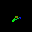

3 expected, 2 found with score 0.898438


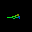

3 expected, 2 found with score 0.933594


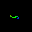

3 expected, 2 found with score 0.921875


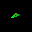

3 expected, 2 found with score 0.894531


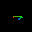

3 expected, 2 found with score 0.664062


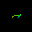

3 expected, 4 found with score 0.660156


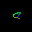

3 expected, 2 found with score 0.574219


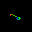

3 expected, 2 found with score 0.792969


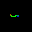

3 expected, 2 found with score 0.492188


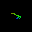

3 expected, 2 found with score 0.375000


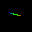

3 expected, 2 found with score 0.902344


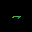

3 expected, 2 found with score 0.449219


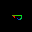

3 expected, 2 found with score 0.324219


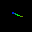

3 expected, 2 found with score 0.710938


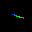

3 expected, 2 found with score 0.710938


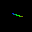

3 expected, 2 found with score 0.921875


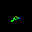

3 expected, 2 found with score 0.898438


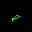

3 expected, 2 found with score 0.433594


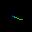

3 expected, 2 found with score 0.953125


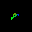

3 expected, 4 found with score 0.789062


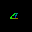

3 expected, 2 found with score 0.640625


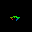

3 expected, 2 found with score 0.800781


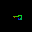

3 expected, 2 found with score 0.546875


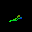

3 expected, 2 found with score 0.898438


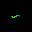

3 expected, 4 found with score 0.601562


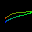

3 expected, 0 found with score 0.417969


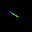

3 expected, 2 found with score 0.542969


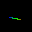

3 expected, 2 found with score 0.949219


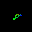

3 expected, 2 found with score 0.628906


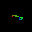

3 expected, 4 found with score 0.832031


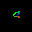

3 expected, 0 found with score 0.675781


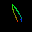

3 expected, 2 found with score 0.898438


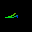

3 expected, 2 found with score 0.796875


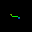

3 expected, 4 found with score 0.687500


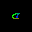

3 expected, 2 found with score 0.847656


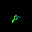

3 expected, 0 found with score 0.386719


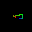

3 expected, 2 found with score 0.558594


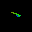

3 expected, 2 found with score 0.460938


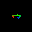

3 expected, 4 found with score 0.804688


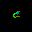

3 expected, 2 found with score 0.542969


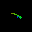

3 expected, 2 found with score 0.738281


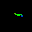

3 expected, 0 found with score 0.281250


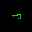

3 expected, 2 found with score 0.593750


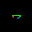

3 expected, 4 found with score 0.582031


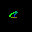

3 expected, 2 found with score 0.687500


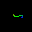

3 expected, 2 found with score 0.718750


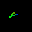

3 expected, 2 found with score 0.949219


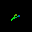

3 expected, 2 found with score 0.613281


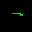

3 expected, 2 found with score 0.894531


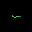

3 expected, 2 found with score 0.718750


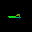

3 expected, 2 found with score 0.937500


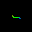

3 expected, 2 found with score 0.906250


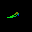

3 expected, 2 found with score 0.886719


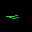

3 expected, 0 found with score 0.742188


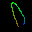

3 expected, 2 found with score 0.324219


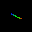

3 expected, 2 found with score 0.878906


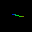

3 expected, 2 found with score 0.878906


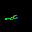

3 expected, 2 found with score 0.695312


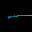

3 expected, 1 found with score 0.476562


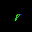

1 expected, 0 found with score 0.593750


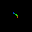

1 expected, 0 found with score 0.773438


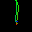

1 expected, 0 found with score 0.761719


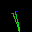

1 expected, 2 found with score 0.679688


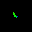

1 expected, 0 found with score 0.742188


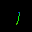

1 expected, 0 found with score 0.718750


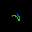

1 expected, 0 found with score 0.695312


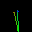

1 expected, 0 found with score 0.789062


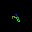

1 expected, 0 found with score 0.550781


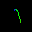

1 expected, 0 found with score 0.558594


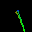

1 expected, 0 found with score 0.882812


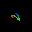

1 expected, 0 found with score 0.535156


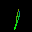

1 expected, 0 found with score 0.531250


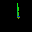

1 expected, 0 found with score 0.855469


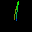

1 expected, 0 found with score 0.601562


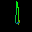

1 expected, 0 found with score 0.597656


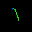

1 expected, 0 found with score 0.746094


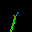

1 expected, 0 found with score 0.648438


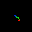

1 expected, 0 found with score 0.722656


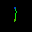

1 expected, 0 found with score 0.566406


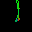

1 expected, 0 found with score 0.566406


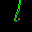

1 expected, 0 found with score 0.664062


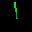

1 expected, 0 found with score 0.562500


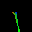

1 expected, 0 found with score 0.535156


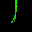

1 expected, 0 found with score 0.835938


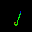

1 expected, 0 found with score 0.566406


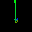

1 expected, 0 found with score 0.863281


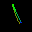

1 expected, 0 found with score 0.660156


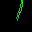

1 expected, 0 found with score 0.500000


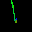

1 expected, 0 found with score 0.601562


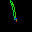

1 expected, 0 found with score 0.535156


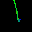

1 expected, 0 found with score 0.765625


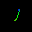

1 expected, 0 found with score 0.910156


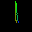

1 expected, 0 found with score 0.722656


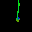

1 expected, 0 found with score 0.785156


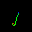

1 expected, 0 found with score 0.800781


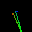

1 expected, 2 found with score 0.652344


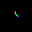

1 expected, 0 found with score 0.531250


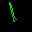

1 expected, 0 found with score 0.664062


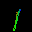

1 expected, 0 found with score 0.742188


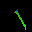

1 expected, 3 found with score 0.660156


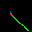

1 expected, 0 found with score 0.542969


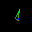

1 expected, 0 found with score 0.722656


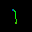

1 expected, 0 found with score 0.773438


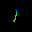

1 expected, 0 found with score 0.410156


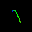

1 expected, 0 found with score 0.664062


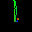

1 expected, 0 found with score 0.718750


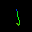

1 expected, 0 found with score 0.632812


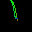

1 expected, 0 found with score 0.535156


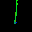

1 expected, 0 found with score 0.796875


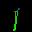

1 expected, 0 found with score 0.632812


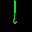

1 expected, 0 found with score 0.546875


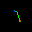

1 expected, 0 found with score 0.683594


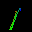

1 expected, 0 found with score 0.527344


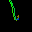

1 expected, 0 found with score 0.601562


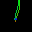

1 expected, 0 found with score 0.500000


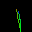

1 expected, 0 found with score 0.683594


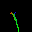

1 expected, 0 found with score 0.632812


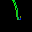

1 expected, 0 found with score 0.500000


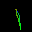

1 expected, 0 found with score 0.750000


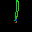

1 expected, 0 found with score 0.601562


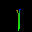

1 expected, 0 found with score 0.718750


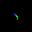

1 expected, 0 found with score 0.500000


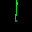

1 expected, 0 found with score 0.593750


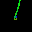

1 expected, 0 found with score 0.601562


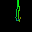

1 expected, 4 found with score 0.445312


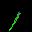

1 expected, 0 found with score 0.843750


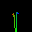

1 expected, 0 found with score 0.597656


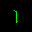

1 expected, 0 found with score 0.500000


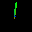

1 expected, 0 found with score 0.796875


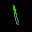

1 expected, 0 found with score 0.566406


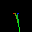

1 expected, 0 found with score 0.566406


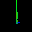

1 expected, 0 found with score 0.890625


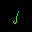

1 expected, 0 found with score 0.500000


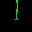

1 expected, 0 found with score 0.542969


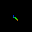

1 expected, 0 found with score 0.691406


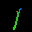

1 expected, 0 found with score 0.535156


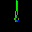

1 expected, 0 found with score 0.773438


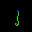

1 expected, 0 found with score 0.769531


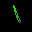

1 expected, 2 found with score 0.636719


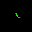

1 expected, 0 found with score 0.812500


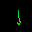

1 expected, 0 found with score 0.769531


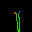

1 expected, 0 found with score 0.722656


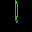

1 expected, 0 found with score 0.781250


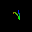

1 expected, 0 found with score 0.601562


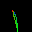

1 expected, 0 found with score 0.871094


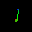

1 expected, 0 found with score 0.734375


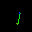

1 expected, 0 found with score 0.535156


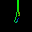

1 expected, 0 found with score 0.796875


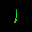

1 expected, 0 found with score 0.511719


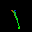

1 expected, 2 found with score 0.511719


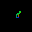

1 expected, 0 found with score 0.750000


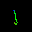

1 expected, 4 found with score 0.542969


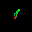

1 expected, 0 found with score 0.550781


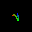

1 expected, 0 found with score 0.566406


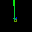

1 expected, 0 found with score 0.566406


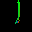

1 expected, 0 found with score 0.761719


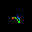

1 expected, 0 found with score 0.765625


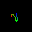

1 expected, 0 found with score 0.453125


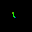

1 expected, 0 found with score 0.585938


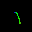

1 expected, 0 found with score 0.945312


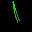

1 expected, 0 found with score 0.660156


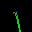

1 expected, 2 found with score 0.410156


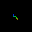

1 expected, 0 found with score 0.601562


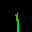

1 expected, 0 found with score 0.632812


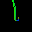

1 expected, 0 found with score 0.500000


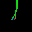

1 expected, 0 found with score 0.839844


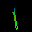

1 expected, 0 found with score 0.566406


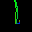

1 expected, 0 found with score 0.750000


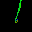

1 expected, 0 found with score 0.902344


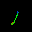

1 expected, 0 found with score 0.597656


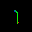

1 expected, 2 found with score 0.671875


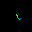

1 expected, 0 found with score 0.500000


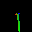

1 expected, 0 found with score 0.855469


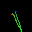

1 expected, 0 found with score 0.695312


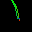

1 expected, 0 found with score 0.496094


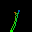

1 expected, 0 found with score 0.589844


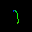

1 expected, 0 found with score 0.492188


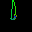

1 expected, 0 found with score 0.722656


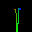

1 expected, 2 found with score 0.472656


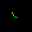

1 expected, 0 found with score 0.695312


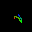

1 expected, 0 found with score 0.898438


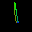

1 expected, 2 found with score 0.355469


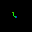

1 expected, 0 found with score 0.453125


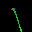

1 expected, 0 found with score 0.632812


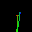

1 expected, 0 found with score 0.878906


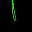

1 expected, 0 found with score 0.722656


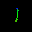

1 expected, 0 found with score 0.535156


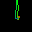

1 expected, 0 found with score 0.500000


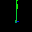

1 expected, 0 found with score 0.503906


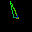

1 expected, 0 found with score 0.492188


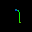

1 expected, 0 found with score 0.566406


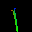

1 expected, 2 found with score 0.453125


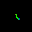

1 expected, 0 found with score 0.652344


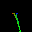

1 expected, 0 found with score 0.535156


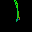

1 expected, 0 found with score 0.394531


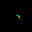

1 expected, 0 found with score 0.722656


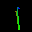

1 expected, 0 found with score 0.492188


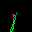

1 expected, 0 found with score 0.695312


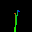

1 expected, 0 found with score 0.820312


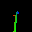

1 expected, 0 found with score 0.656250


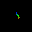

1 expected, 0 found with score 0.496094


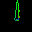

1 expected, 0 found with score 0.664062


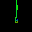

1 expected, 0 found with score 0.507812


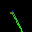

1 expected, 0 found with score 0.902344


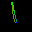

1 expected, 0 found with score 0.632812


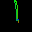

1 expected, 0 found with score 0.695312


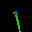

1 expected, 0 found with score 0.566406


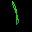

1 expected, 0 found with score 0.500000


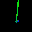

1 expected, 0 found with score 0.691406


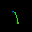

1 expected, 0 found with score 0.644531


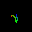

1 expected, 0 found with score 0.773438


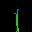

1 expected, 0 found with score 0.707031


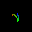

1 expected, 0 found with score 0.609375


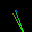

1 expected, 0 found with score 0.750000


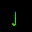

1 expected, 0 found with score 0.570312


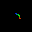

1 expected, 0 found with score 0.910156


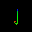

1 expected, 0 found with score 0.601562


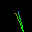

1 expected, 0 found with score 0.566406


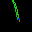

1 expected, 0 found with score 0.644531


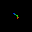

1 expected, 0 found with score 0.929688


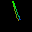

1 expected, 0 found with score 0.773438


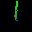

1 expected, 0 found with score 0.792969


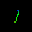

1 expected, 2 found with score 0.781250


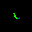

1 expected, 0 found with score 0.500000


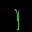

1 expected, 0 found with score 0.734375


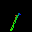

1 expected, 0 found with score 0.570312


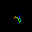

1 expected, 0 found with score 0.566406


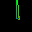

1 expected, 0 found with score 0.679688


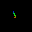

1 expected, 0 found with score 0.531250


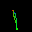

1 expected, 0 found with score 0.835938


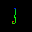

1 expected, 0 found with score 0.792969


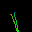

1 expected, 0 found with score 0.796875


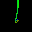

1 expected, 0 found with score 0.632812


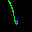

1 expected, 0 found with score 0.515625


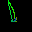

1 expected, 0 found with score 0.761719


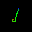

1 expected, 0 found with score 0.632812


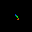

1 expected, 0 found with score 0.820312


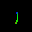

1 expected, 0 found with score 0.535156


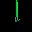

1 expected, 0 found with score 0.664062


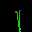

4 expected, 0 found with score 0.601562


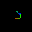

4 expected, 1 found with score 0.429688


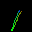

4 expected, 2 found with score 0.750000


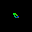

4 expected, 2 found with score 0.929688


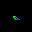

4 expected, 0 found with score 0.570312


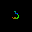

4 expected, 1 found with score 0.746094


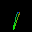

4 expected, 0 found with score 0.492188


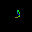

4 expected, 1 found with score 0.730469


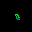

4 expected, 1 found with score 0.433594


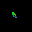

4 expected, 1 found with score 0.792969


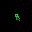

4 expected, 2 found with score 0.718750


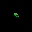

4 expected, 1 found with score 0.429688


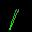

4 expected, 2 found with score 0.761719


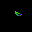

4 expected, 3 found with score 0.484375


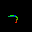

4 expected, 2 found with score 0.433594


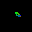

4 expected, 1 found with score 0.394531


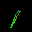

4 expected, 1 found with score 0.394531


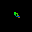

4 expected, 1 found with score 0.785156


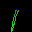

4 expected, 1 found with score 0.476562


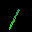

4 expected, 0 found with score 0.375000


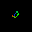

4 expected, 0 found with score 0.550781


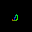

4 expected, 1 found with score 0.511719


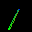

4 expected, 1 found with score 0.460938


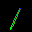

4 expected, 0 found with score 0.367188


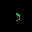

4 expected, 1 found with score 0.347656


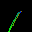

4 expected, 2 found with score 0.519531


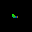

4 expected, 1 found with score 0.398438


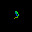

4 expected, 1 found with score 0.425781


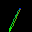

4 expected, 2 found with score 0.687500


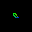

0 expected, 2 found with score 0.871094


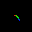

0 expected, 1 found with score 0.691406


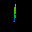

0 expected, 2 found with score 0.660156


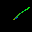

0 expected, 1 found with score 0.789062


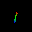

0 expected, 1 found with score 0.632812


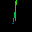

0 expected, 1 found with score 0.535156


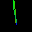

0 expected, 1 found with score 0.558594


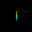

0 expected, 1 found with score 0.558594


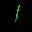

0 expected, 1 found with score 0.601562


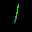

0 expected, 1 found with score 0.566406


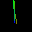

0 expected, 1 found with score 0.566406


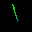

0 expected, 1 found with score 0.601562


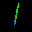

0 expected, 1 found with score 0.527344


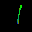

0 expected, 1 found with score 0.593750


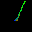

0 expected, 3 found with score 0.851562


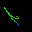

0 expected, 3 found with score 0.988281


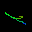

0 expected, 1 found with score 0.531250


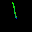

0 expected, 3 found with score 0.601562


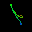

0 expected, 1 found with score 0.664062


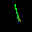

0 expected, 3 found with score 0.410156


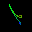

0 expected, 2 found with score 0.402344


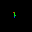

0 expected, 2 found with score 0.316406


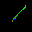

0 expected, 1 found with score 0.515625


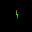

0 expected, 1 found with score 0.542969


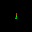

0 expected, 1 found with score 0.621094


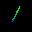

0 expected, 1 found with score 0.609375


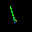

0 expected, 1 found with score 0.472656


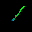

0 expected, 1 found with score 0.492188


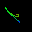

0 expected, 1 found with score 0.625000


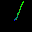

0 expected, 1 found with score 0.578125


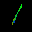

0 expected, 3 found with score 0.636719


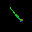

0 expected, 1 found with score 0.660156


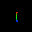

0 expected, 1 found with score 0.531250


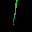

0 expected, 1 found with score 0.535156


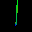

0 expected, 1 found with score 0.632812


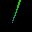

0 expected, 2 found with score 0.507812


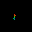

0 expected, 1 found with score 0.558594


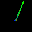

0 expected, 3 found with score 0.890625


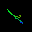

0 expected, 2 found with score 0.519531


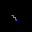

0 expected, 1 found with score 0.601562


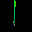

0 expected, 2 found with score 0.476562


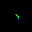

0 expected, 1 found with score 0.636719


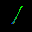

0 expected, 1 found with score 0.531250


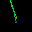

0 expected, 1 found with score 0.531250


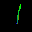

0 expected, 1 found with score 0.535156


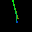

0 expected, 1 found with score 0.566406


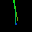

0 expected, 1 found with score 0.664062


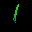

0 expected, 3 found with score 0.984375


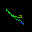

0 expected, 1 found with score 0.566406


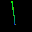

0 expected, 1 found with score 0.535156


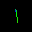

0 expected, 1 found with score 0.695312


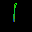

0 expected, 1 found with score 0.558594


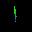

0 expected, 1 found with score 0.531250


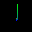

0 expected, 1 found with score 0.664062


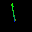

0 expected, 2 found with score 0.378906


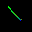

0 expected, 1 found with score 0.750000


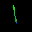

0 expected, 1 found with score 0.562500


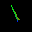

0 expected, 3 found with score 0.933594


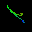

0 expected, 1 found with score 0.425781


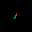

0 expected, 1 found with score 0.566406


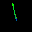

0 expected, 1 found with score 0.535156


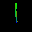

0 expected, 4 found with score 0.644531


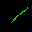

0 expected, 2 found with score 0.898438


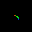

0 expected, 1 found with score 0.574219


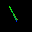

0 expected, 1 found with score 0.519531


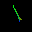

0 expected, 1 found with score 0.687500


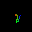

0 expected, 1 found with score 0.535156


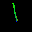

0 expected, 1 found with score 0.628906


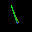

0 expected, 4 found with score 0.640625


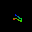

0 expected, 1 found with score 0.566406


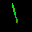

0 expected, 1 found with score 0.441406


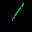

0 expected, 1 found with score 0.531250


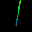

0 expected, 1 found with score 0.390625


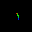

0 expected, 1 found with score 0.601562


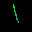

0 expected, 3 found with score 0.957031


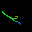

0 expected, 1 found with score 0.664062


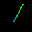

0 expected, 1 found with score 0.566406


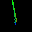

0 expected, 1 found with score 0.832031


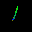

0 expected, 1 found with score 0.566406


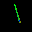

0 expected, 1 found with score 0.488281


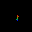

0 expected, 2 found with score 0.519531


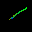

0 expected, 1 found with score 0.722656


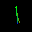

0 expected, 1 found with score 0.589844


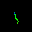

0 expected, 1 found with score 0.453125


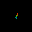

0 expected, 1 found with score 0.335938


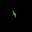

0 expected, 4 found with score 0.714844


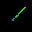

0 expected, 1 found with score 0.531250


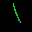

0 expected, 1 found with score 0.546875


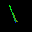

0 expected, 2 found with score 0.386719


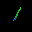

0 expected, 1 found with score 0.527344


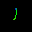

0 expected, 2 found with score 0.777344


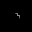

0 expected, 3 found with score 0.914062


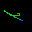

0 expected, 1 found with score 0.527344


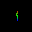

0 expected, 1 found with score 0.562500


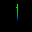

0 expected, 2 found with score 0.500000


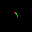

0 expected, 1 found with score 0.535156


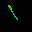

0 expected, 1 found with score 0.535156


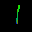

0 expected, 1 found with score 0.566406


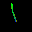

0 expected, 2 found with score 0.824219


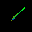

0 expected, 1 found with score 0.750000


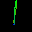

0 expected, 3 found with score 0.968750


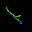

0 expected, 1 found with score 0.722656


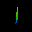

0 expected, 1 found with score 0.601562


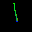

0 expected, 2 found with score 0.546875


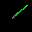

0 expected, 1 found with score 0.597656


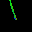

0 expected, 1 found with score 0.535156


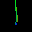

0 expected, 1 found with score 0.523438


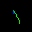

0 expected, 1 found with score 0.632812


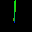

0 expected, 1 found with score 0.507812


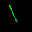

0 expected, 1 found with score 0.535156


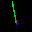

0 expected, 1 found with score 0.664062


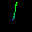

0 expected, 1 found with score 0.492188


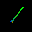

0 expected, 1 found with score 0.531250


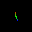

84.3% correct (N=2893, 140 below threshold)


In [65]:
from IPython.display import Image, display

SCORE_THRESHOLD = 0.5
correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test/*"):
  label = int(label_dir.replace("test/", ""))
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_tflite(model_FIQ, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
      print("%d expected, %d found with score %f" % (label, index, score))
      display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

print("%.1f%% correct (N=%d, %d below threshold)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

In [66]:
import os
import pandas as pd

def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,284377 bytes,
TensorFlow Lite,27960 bytes,(reduced by 256417 bytes)
TensorFlow Lite Quantized,11352 bytes,(reduced by 16608 bytes)


In [67]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 2s (97.2 kB/s)
Reading package lists... Done


In [30]:
# Print the C source file
!tail {TFL_CC_MODEL_FILENAME}

  0x04, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xd0, 0xff, 0xff, 0xff,
  0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x19,
  0xe0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x09, 0xf0, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x28, 0x0c, 0x00, 0x10, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03
};
unsigned int g_gesture_model_data_len = 9888;
